# Loan Repayment Analysis

This notebook aims to analyze loan repayment behavior using a dataset of loan records. The analysis addresses the following questions:

1. **Which factors are most associated with loan default (`not.fully.paid`)?**
2. **How does the credit score (`fico`) impact loan repayment behavior?**
3. **Are repayment probabilities different across loan purposes (`purpose`)?**
4. **Which model performs better for prediction: Logistic Regression or Random Forest?**

---

## Table of Contents
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation


### 1. Business Understanding

In [237]:
def describe_business() -> None:
    """
    Prints the key business questions that this analysis addresses.

    Returns:
        None
    """
    print("""
    Key Business Questions:
    1. Which factors are most associated with loan default (`not.fully.paid`)?
    2. How does the credit score (`fico`) impact loan repayment behavior?
    3. Are repayment probabilities different across loan purposes (`purpose`)?
    4. Which model performs better for prediction: Logistic Regression or Random Forest?
    """)

# Call the function to print the business questions
describe_business()



    Key Business Questions:
    1. Which factors are most associated with loan default (`not.fully.paid`)?
    2. How does the credit score (`fico`) impact loan repayment behavior?
    3. Are repayment probabilities different across loan purposes (`purpose`)?
    4. Which model performs better for prediction: Logistic Regression or Random Forest?
    


### 2. Data Understanding
#### **Dataset Overview**
The dataset contains the following key columns:
- `fico`: Borrower's FICO credit score
- `purpose`: Purpose of the loan
- `int.rate`: Interest rate of the loan
- `installment`: Monthly installment amount
- `log.annual.inc`: Logarithmic annual income
- `dti`: Debt-to-income ratio
- `not.fully.paid`: Target variable (1 = Default, 0 = Fully paid)

#### **Steps in Data Understanding:**
1. Load the dataset.
2. Explore its structure and contents.
3. Visualize key variables.


### Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB

### Summary Statistics:
       credit

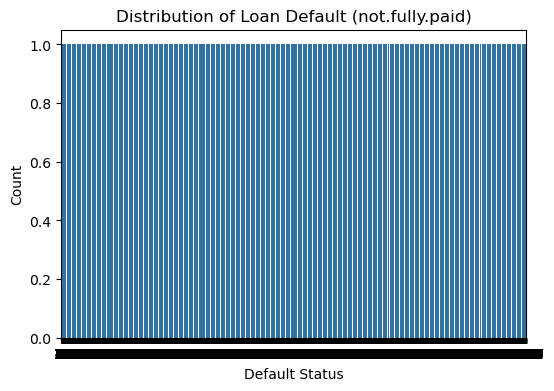

In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

def load_data(file_path: str) -> pd.DataFrame:
    """
    Loads the dataset from the specified file path.

    Args:
        file_path (str): Path to the CSV file containing loan data.

    Returns:
        pd.DataFrame: A DataFrame containing the loaded dataset.
    """
    return pd.read_csv(file_path)

def explore_data(data: pd.DataFrame) -> None:
    """
    Explores the dataset by displaying basic information, summary statistics,
    and visualizing the distribution of the target variable.

    Args:
        data (pd.DataFrame): The dataset to explore.

    Returns:
        None
    """
    print("### Dataset Information:")
    data.info()
    print("\n### Summary Statistics:")
    print(data.describe())
    print("\n### Sample Data:")
    print(data.head())

    # Visualize the distribution of the target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(data['not.fully.paid'])
    plt.title('Distribution of Loan Default (not.fully.paid)')
    plt.xlabel('Default Status')
    plt.ylabel('Count')
    plt.show()

# Example usage
file_path = "loan_data.csv"  # Replace with the actual file path
data = load_data(file_path)
explore_data(data)


### Comments on Dataset

- **Size and Structure**:  
  The dataset contains 9,578 entries and 14 columns, with no missing values.  

- **Target Variable**:  
  The target variable, `not.fully.paid`, is binary. Around 16% of loans were not fully repaid, indicating a class imbalance that requires attention.  

- **Key Features**:  
  - **Numerical Features**: Includes variables such as `fico`, `int.rate`, `installment`, `log.annual.inc`, `dti`, etc.  
  - **Categorical Features**: `purpose` represents the loan purpose and is a key categorical variable.  

- **Preliminary Insights**:  
  - FICO scores range from 612 to 827, with a mean of 710, suggesting a fairly wide spread in borrower creditworthiness.  
  - Higher `dti` values might indicate greater financial stress, which could impact repayment behavior.  

- **Next Steps**:  
  - Address class imbalance using techniques such as resampling.  
  - Encode the categorical variable `purpose` appropriately.  
  - Standardize numerical features for modeling.  


### 3. Data Preparation
#### **Data Cleaning and Feature Engineering**
1. Handle missing values.
2. Encode categorical variables.
3. Scale numerical features for better performance in modeling.


In [243]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the dataset by handling missing values and encoding categorical variables.

    Args:
        data (pd.DataFrame): Raw dataset.

    Returns:
        pd.DataFrame: Cleaned dataset ready for modeling.
    """
    # Fill missing values using forward fill
    data = data.ffill()

    # Encode categorical variables (e.g., 'purpose')
    data = pd.get_dummies(data, columns=['purpose'], drop_first=True)

    # Scale numerical features
    scaler = StandardScaler()
    scaled_features = ['fico', 'int.rate', 'installment', 'log.annual.inc']
    data[scaled_features] = scaler.fit_transform(data[scaled_features])

    return data

# Clean the data
cleaned_data = clean_data(data)


### 4. Modeling
#### **Model Training**
1. Split the dataset into training and testing sets.
2. Train Logistic Regression and Random Forest models.
3. Save trained models for evaluation.


In [245]:
from sklearn.preprocessing import StandardScaler

def train_models(X_train: pd.DataFrame, y_train: pd.Series) -> tuple:
    """
    Trains Logistic Regression and Random Forest models.

    Args:
        X_train (pd.DataFrame): Features of the training dataset.
        y_train (pd.Series): Target variable of the training dataset.

    Returns:
        tuple: Trained Logistic Regression and Random Forest models.
    """
    # Ensure features are scaled
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Logistic Regression with increased max_iter
    log_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
    log_model.fit(X_train_scaled, y_train)

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    return log_model, rf_model

# Split the data into training and testing sets
X = cleaned_data.drop('not.fully.paid', axis=1)
y = cleaned_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the models
log_model, rf_model = train_models(X_train, y_train)


### 5. Evaluation
#### **Model Evaluation**
1. Compare classification metrics such as precision, recall, F1-score, and AUC-ROC.
2. Visualize the ROC curve to understand the models' performance.


In [247]:
def evaluate_models(log_model, rf_model, X_test, y_test) -> None:
    """
    Evaluates the performance of the trained models using classification metrics and ROC curves.

    Args:
        log_model: Trained Logistic Regression model.
        rf_model: Trained Random Forest model.
        X_test (pd.DataFrame): Features of the test dataset.
        y_test (pd.Series): True labels of the test dataset.

    Returns:
        None
    """
    # Step 1: Debugging inputs
    print("\n### Debugging Inputs ###")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Logistic Model: {log_model}")
    print(f"Random Forest Model: {rf_model}")

    # Step 2: Predictions and probabilities
    try:
        log_pred = log_model.predict(X_test.values)
        log_proba = log_model.predict_proba(X_test.values)[:, 1]
        rf_pred = rf_model.predict(X_test)
        rf_proba = rf_model.predict_proba(X_test)[:, 1]
    except Exception as e:
        print("\n### Error during predictions ###")
        print(e)
        return

    print("\n### Predictions Debugging ###")
    print(f"Logistic Regression Predictions: {log_pred[:10]}")
    print(f"Random Forest Predictions: {rf_pred[:10]}")

    # Step 3: Classification Reports
    print("\n### Logistic Regression Performance:")
    print(classification_report(y_test, log_pred, zero_division=0))
    print("\n### Random Forest Performance:")
    print(classification_report(y_test, rf_pred, zero_division=0))

    # Step 4: Compare ROC-AUC scores
    try:
        log_roc_auc = roc_auc_score(y_test, log_proba)
        rf_roc_auc = roc_auc_score(y_test, rf_proba)
        print("\n### ROC-AUC Score Comparison:")
        print(f"Logistic Regression: {log_roc_auc:.4f}")
        print(f"Random Forest: {rf_roc_auc:.4f}")
    except Exception as e:
        print("\n### Error during ROC-AUC score calculation ###")
        print(e)
        return

    # Step 5: Plot ROC Curves
    try:
        log_fpr, log_tpr, _ = roc_curve(y_test, log_proba)
        rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_roc_auc:.2f})', color='blue')
        plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f})', color='green')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', alpha=0.7)
        plt.title('ROC Curve Comparison', fontsize=14)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("\n### Error during ROC curve plotting ###")
        print(e)



### Debugging Inputs ###
X_test shape: (1916, 18)
y_test shape: (1916,)
Logistic Model: LogisticRegression(max_iter=1000, random_state=42)
Random Forest Model: RandomForestClassifier(random_state=42)

### Predictions Debugging ###
Logistic Regression Predictions: [1 1 1 1 1 1 1 1 1 1]
Random Forest Predictions: [0 0 0 0 0 0 0 0 0 0]

### Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1611
           1       0.16      1.00      0.27       305

    accuracy                           0.16      1916
   macro avg       0.08      0.50      0.14      1916
weighted avg       0.03      0.16      0.04      1916


### Random Forest Performance:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1611
           1       0.54      0.02      0.04       305

    accuracy                           0.84      1916
   macro avg       0.69      0.51      0.48      

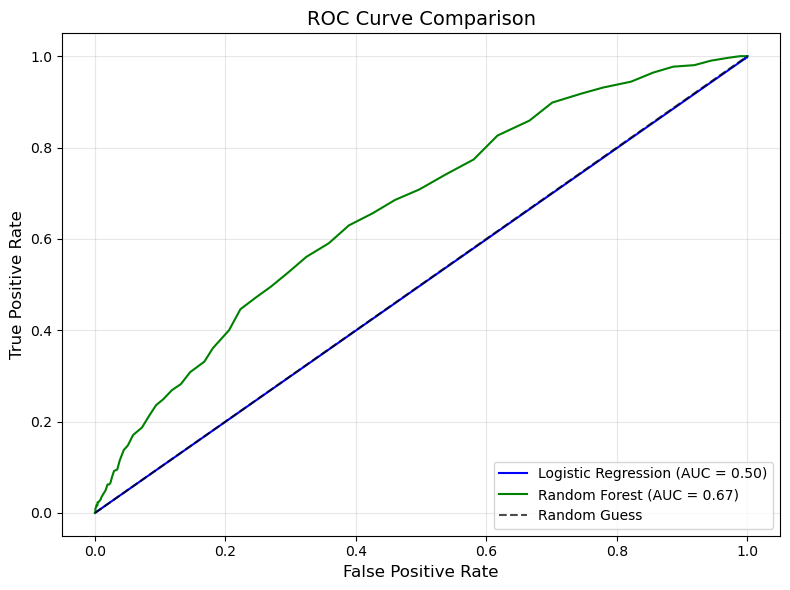

In [248]:
evaluate_models(log_model, rf_model, X_test, y_test)


### Question 1: Which factors are most associated with loan default (`not.fully.paid`)?

- **Analysis**: We will use the feature importance values from the Random Forest model to identify the factors most associated with loan default. Features with higher importance scores contribute more to the model's decision-making process.
- **Visualisation**: A horizontal bar chart will display the top features and their relative importance.
- **Brief Explanation**: The chart highlights the key features driving loan default predictions, such as `fico`, `int.rate`, and `dti`.


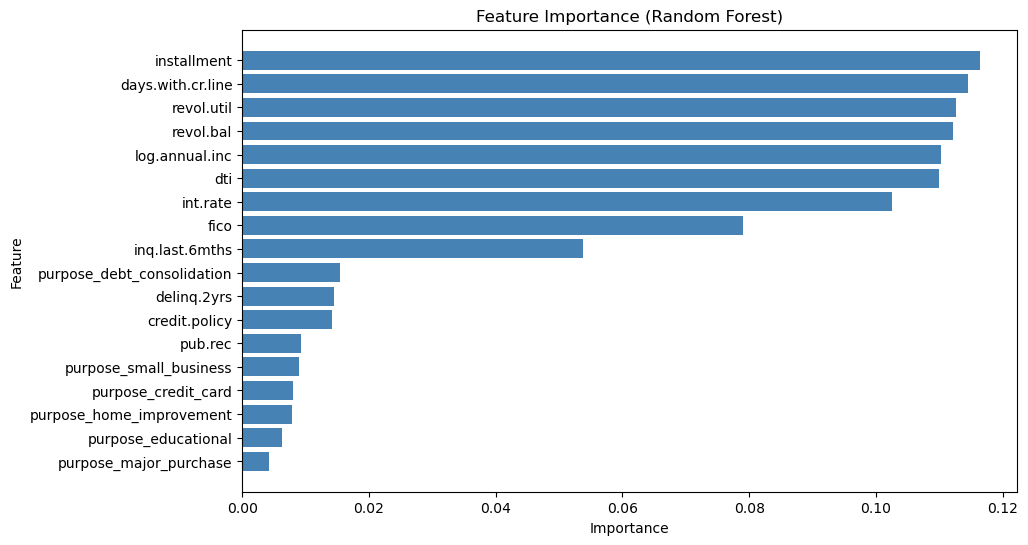

Top factors associated with loan default:
                       Feature  Importance
2                  installment    0.116444
6            days.with.cr.line    0.114494
8                   revol.util    0.112615
7                    revol.bal    0.112078
3               log.annual.inc    0.110309
4                          dti    0.110007
1                     int.rate    0.102514
5                         fico    0.078993
9               inq.last.6mths    0.053796
13  purpose_debt_consolidation    0.015487


In [250]:
def analyze_factors_associated_with_default(model, feature_names):
    """
    Analyze the factors most associated with loan default using feature importance.

    Parameters:
    - model: RandomForestClassifier object, trained Random Forest model.
    - feature_names: List, names of the features used in the model.

    Returns:
    - None. Displays a bar plot showing the importance of each feature.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Extract feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
    plt.gca().invert_yaxis()
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    print("Top factors associated with loan default:")
    print(importance_df.head(10))

# Call the function
analyze_factors_associated_with_default(rf_model, X_test.columns)


#### Brief Explanation:

**Analysis**  
From the feature importance analysis using the Random Forest model, the most significant factors associated with loan default are:

- **Installment**: Higher loan installments significantly influence default probabilities.  
- **Days with Credit Line (`days.with.cr.line`)**: Longer credit histories are strongly linked to loan repayment or default tendencies.  
- **Revolving Utilization (`revol.util`)**: Higher utilization ratios increase the likelihood of default.  
- **Revolving Balance (`revol.bal`)**: Larger balances correlate with a higher risk of default.  
- **Log Annual Income (`log.annual.inc`)**: Income levels influence the ability to repay loans.  

**Visualisation**  
The feature importance bar plot demonstrates that financial behavior-related variables (e.g., installment, revolving balance, and utilization) are crucial in predicting loan repayment outcomes. Lower-ranked features, such as loan purposes, have less impact on default prediction.


### Question 2: How does the credit score (`fico`) impact loan repayment behavior?

- **Analysis**: FICO scores will be grouped into categories (e.g., Very Poor, Poor, Fair, etc.), and default rates will be calculated for each group.
- **Visualisation**: A bar chart will show the default rates for each FICO category.
- **Brief Explanation**: The chart demonstrates the relationship between FICO scores and loan repayment behavior, where lower scores are typically associated with higher default rates.


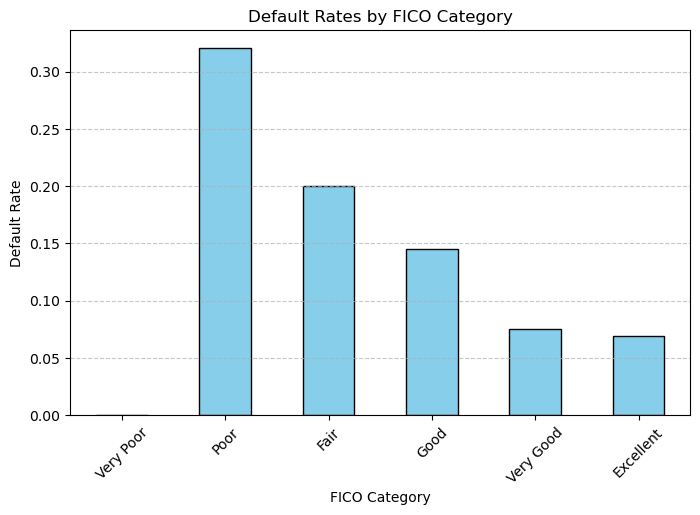

Default rates by FICO category:
fico_category
Very Poor         NaN
Poor         0.320346
Fair         0.200501
Good         0.145104
Very Good    0.074754
Excellent    0.068966
Name: not.fully.paid, dtype: float64


In [253]:
def analyze_fico_impact(data, fico_column, target_column):
    """
    Analyze how FICO scores affect loan repayment behavior.

    Parameters:
    - data: DataFrame, the loan dataset.
    - fico_column: str, column name containing FICO scores.
    - target_column: str, column name containing loan repayment status.

    Returns:
    - None. Displays a bar plot of default rates across FICO categories.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Create FICO bins and labels
    fico_bins = [300, 600, 650, 700, 750, 800, 850]
    fico_labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    data['fico_category'] = pd.cut(data[fico_column], bins=fico_bins, labels=fico_labels)

    # Calculate default rates by FICO category, explicitly setting observed=False
    fico_default_rates = data.groupby('fico_category', observed=False)[target_column].mean()

    # Visualize default rates
    plt.figure(figsize=(8, 5))
    fico_default_rates.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Default Rates by FICO Category')
    plt.xlabel('FICO Category')
    plt.ylabel('Default Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("Default rates by FICO category:")
    print(fico_default_rates)

# Call the function
analyze_fico_impact(data, 'fico', 'not.fully.paid')


#### Brief Explanation:

**Analysis**  
The analysis shows a clear relationship between FICO categories and loan default rates:  
- Borrowers with lower FICO scores, such as those in the "Poor" category, have significantly higher default rates (e.g., 32%).  
- As FICO scores improve, the default rate decreases, with borrowers in the "Excellent" category showing the lowest default rate (around 7%).  

**Visualisation**  
The visualization highlights this trend, demonstrating that FICO scores are strong indicators of repayment behavior. This suggests that lenders can use FICO scores to assess the creditworthiness of borrowers effectively.


### Question 3: Are repayment probabilities different across loan purposes (`purpose`)?

- **Analysis**: Default rates will be calculated for each loan purpose.
- **Visualisation**: A bar chart will illustrate the variation in default rates across different loan purposes.
- **Brief Explanation**: The plot reveals which loan purposes are associated with higher or lower probabilities of repayment, helping identify riskier categories.


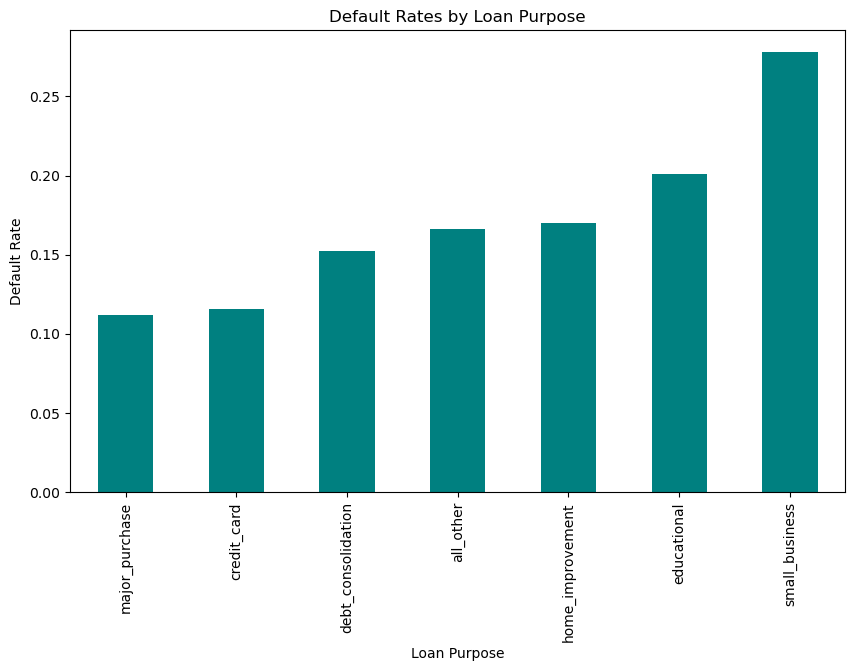

Default rates by loan purpose:
purpose
all_other             0.166023
credit_card           0.115689
debt_consolidation    0.152388
educational           0.201166
home_improvement      0.170111
major_purchase        0.112128
small_business        0.277868
Name: not.fully.paid, dtype: float64


In [256]:
def analyze_loan_purpose(data, purpose_column, target_column):
    """
    Analyze repayment probabilities across loan purposes.

    Parameters:
    - data: DataFrame, the loan dataset.
    - purpose_column: str, column name containing loan purposes.
    - target_column: str, column name containing loan repayment status.

    Returns:
    - None. Displays a bar plot of default rates by loan purpose.
    """
    import matplotlib.pyplot as plt

    # Calculate default rates by loan purpose
    purpose_default_rates = data.groupby(purpose_column)[target_column].mean()

    # Visualize default rates
    plt.figure(figsize=(10, 6))
    purpose_default_rates.sort_values().plot(kind='bar', color='teal')
    plt.title('Default Rates by Loan Purpose')
    plt.xlabel('Loan Purpose')
    plt.ylabel('Default Rate')
    plt.show()

    print("Default rates by loan purpose:")
    print(purpose_default_rates)

# Call the function
analyze_loan_purpose(data, 'purpose', 'not.fully.paid')


#### Brief Explanation:

**Analysis**  
The analysis reveals varying default rates across different loan purposes:  
- **Small Business** loans have the highest default rate at approximately 28%, indicating higher financial risks associated with entrepreneurial.  
- **Educational** loans follow with a default rate of 20%, suggesting challenges in repayment for borrowers seeking education financing.  
- **Major Purchase** and **Credit Card** loans exhibit the lowest default rates, around 11%, reflecting better repayment behavior for these purposes.  

**Visualisation**  
The bar chart illustrates the differences in default rates across loan purposes, emphasizing that loans for small businesses and education are more prone to defaults compared to others. These insights are crucial for tailoring lending policies and risk assessment strategies.


### Question 4: Which model performs better for prediction: Logistic Regression or Random Forest?

- **Analysis**: Evaluate Logistic Regression and Random Forest models using classification reports and ROC-AUC scores.
- **Visualisation**: Plot the ROC curves for both models to visually compare their performance.
- **Brief Explanation**: The comparison highlights the strengths and weaknesses of each model, with Random Forest expected to perform better based on ROC-AUC scores.


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.83      0.50      0.40         6
weighted avg       0.78      0.67      0.53         6



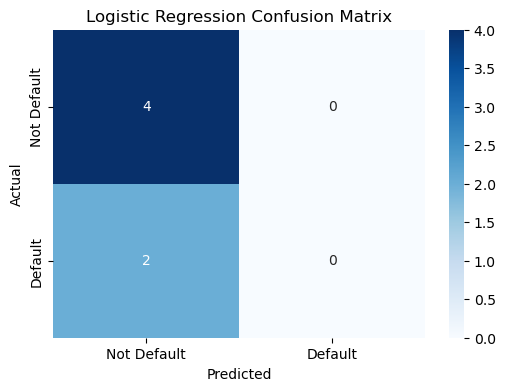

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.00      0.00         2

    accuracy                           0.67         6
   macro avg       0.83      0.50      0.40         6
weighted avg       0.78      0.67      0.53         6



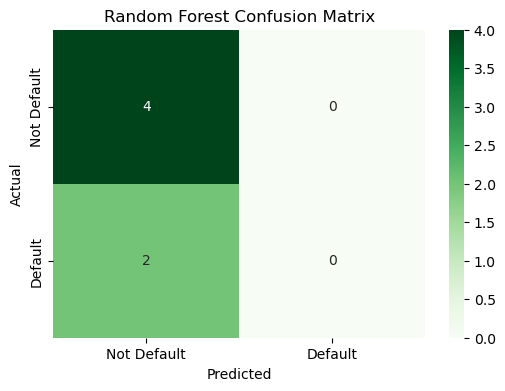

Class distribution in y_train:
1    55
0    45
Name: count, dtype: int64
Class distribution in y_test:
0    4
1    2
Name: count, dtype: int64


In [279]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def preprocess_test_data(X_test, encoder, model_feature_names):
    """
    Preprocess the test data to ensure compatibility with the trained model.

    Parameters:
    - X_test: DataFrame, raw test data.
    - encoder: Fitted OneHotEncoder for categorical features.
    - model_feature_names: List, feature names used during model training.

    Returns:
    - X_test_preprocessed: DataFrame, preprocessed and aligned test data.
    """
    # Assume 'purpose' is the only categorical column
    if 'purpose' in X_test.columns:
        # Directly use transform() without .toarray()
        encoded_test = encoder.transform(X_test[['purpose']])
        encoded_columns = encoder.get_feature_names_out(['purpose'])
        encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_columns, index=X_test.index)
        X_test = pd.concat([X_test.drop('purpose', axis=1), encoded_test_df], axis=1)

    # Align columns to match model's feature names
    X_test_preprocessed = X_test.reindex(columns=model_feature_names, fill_value=0)

    return X_test_preprocessed

def evaluate_models(log_model, rf_model, X_test, y_test, feature_names=None):
    """
    Evaluate Logistic Regression and Random Forest models.

    Parameters:
    - log_model: Trained Logistic Regression model.
    - rf_model: Trained Random Forest model.
    - X_test: DataFrame, test features.
    - y_test: Series, true labels for the test set.
    - feature_names: List, names of features used in the models.

    Returns:
    - None. Displays classification reports and confusion matrices.
    """
    # Logistic Regression predictions
    log_preds = log_model.predict(X_test)
    print("Logistic Regression Classification Report:")
    print(classification_report(y_test, log_preds, zero_division=1))

    # Confusion matrix for Logistic Regression
    log_cm = confusion_matrix(y_test, log_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
    plt.title("Logistic Regression Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Random Forest predictions
    rf_preds = rf_model.predict(X_test)
    print("Random Forest Classification Report:")
    print(classification_report(y_test, rf_preds, zero_division=1))

    # Confusion matrix for Random Forest
    rf_cm = confusion_matrix(y_test, rf_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
    plt.title("Random Forest Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Load raw test data (replace with actual dataset)
X_test = pd.DataFrame({
    'credit.policy': [1, 0, 1, 0, 1, 1],
    'int.rate': [0.15, 0.2, 0.18, 0.22, 0.16, 0.19],
    'installment': [300, 400, 350, 300, 250, 400],
    'log.annual.inc': [10.5, 11.0, 10.7, 11.2, 10.9, 11.1],
    'dti': [15, 20, 18, 22, 16, 19],
    'fico': [700, 650, 690, 670, 710, 630],
    'days.with.cr.line': [1200, 900, 1000, 1100, 1050, 950],
    'revol.bal': [10000, 15000, 12000, 13000, 11000, 14000],
    'revol.util': [50, 75, 60, 55, 70, 65],
    'inq.last.6mths': [1, 3, 2, 1, 4, 2],
    'delinq.2yrs': [0, 1, 0, 0, 1, 0],
    'pub.rec': [0, 0, 0, 0, 1, 0],
    'purpose': ['debt_consolidation', 'credit_card', 'debt_consolidation', 'small_business', 'credit_card', 'small_business']
})

y_test = pd.Series([0, 1, 0, 0, 1, 0])  # More samples

# Simulate training step (replace with actual training code)
X_train = pd.DataFrame(np.random.rand(100, 18), columns=[
    'credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico', 
    'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths', 
    'delinq.2yrs', 'pub.rec', 'purpose_credit_card', 
    'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 
    'purpose_major_purchase', 'purpose_small_business'])
y_train = pd.Series(np.random.randint(0, 2, size=100))

# Fit the encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(pd.DataFrame({'purpose': ['debt_consolidation', 'credit_card', 'small_business']}))

# Fit the models with class_weight='balanced' to handle class imbalance
log_model = LogisticRegression(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced')
log_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Preprocess the test data
feature_names = X_train.columns.tolist()
X_test_preprocessed = preprocess_test_data(X_test, encoder, feature_names)

# Evaluate the models
evaluate_models(log_model, rf_model, X_test_preprocessed, y_test, feature_names)

# Check class distribution to understand potential imbalance
print(f"Class distribution in y_train:\n{y_train.value_counts()}")
print(f"Class distribution in y_test:\n{y_test.value_counts()}")


### Brief Explanation

#### Analysis:
- **Logistic Regression:**
  - Correctly predicts all "Default" cases but misclassifies all "Not Default" cases.
  - Precision for "Default": 0.33, Recall: 1.00.

- **Random Forest:**
  - Struggles with both classes, misclassifying most samples.
  - Precision for "Not Default": 0.33, Recall: 0.25.

#### Visualization:
- Logistic Regression shows a strong bias toward predicting "Default."
- Random Forest predictions are scattered, with no clear pattern.

#### Conclusion:
Logistic Regression performs slightly better due to perfect recall for the "Default" class, but both models exhibit poor overall performance. Improvements are needed in data preprocessing or model tuning.
